In [ ]:
# https://www.kaggle.com/code/adityataparia/yolo-v3-object-detector

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import math
from collections import Counter

# utils.py

In [66]:
def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def iou(boxes_preds, boxes_labels, box_format="midpoint", iou_mode = "IoU", eps = 1e-7):
    """
    iou Reference:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # mid_x - width/2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # mid_y - height/2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # mid_x + width/2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # mid_y + height/2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2


    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]  # 굳이 0:1로 하는 이유는 차원을 유지하기 위해서다.
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # width, height of predict and ground truth box
    w1, h1 = box1_x2 - box1_x1, box1_y2 - box1_y1 + eps
    w2, h2 = box2_x2 - box2_x1, box2_y2 - box2_y1 + eps

    # coordinates for intersection
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # width, height of convex(smallest enclosing box)
    C_w = torch.max(box1_x2, box2_x2) - torch.min(box1_x1, box2_x1)
    C_h = torch.max(box1_y2, box2_y2) - torch.min(box1_y1, box2_y1)

    # convex diagonal squared
    c2 = C_w**2 + C_h**2 + eps

    # center distance squared
    p2 = ((box2_x1 + box2_x2 - box1_x1 - box1_x2)**2 + (box2_y1 + box2_y2 - box1_y1 - box1_y2)**2) / 4

    # iou
    box1_area = abs(w1 * h1)
    box2_area = abs(w2 * h2)
    union = box1_area + box2_area - intersection + eps

    iou = intersection / union

    if iou_mode == "GIoU":
        C = abs(C_w * C_h) + eps
        B = abs(w1 * h1)
        B_gt = abs(w2 * h2)

        R_giou = abs(C - (B + B_gt - intersection)) / abs(C)

        return iou - R_giou

    elif iou_mode == "DIoU":
        R_diou = p2 / c2

        return iou - R_diou

    elif iou_mode == "CIoU":
        v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
        with torch.no_grad():
            alpha = v / ((1 - iou) + v + eps)

        R_ciou = p2 / c2 + v * alpha

        return iou - R_ciou

    else:
        return iou
    
    

def nms(bboxes, iou_threshold, threshold, box_format='corners', iou_mode = "IoU"):


    assert type(bboxes) == list


    bboxes = [box for box in bboxes if box[1] > threshold]

    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nmn = []

    while bboxes:

        chosen_box = bboxes.pop(0)


        bboxes = [box for box in bboxes if box[0] != chosen_box[0] \
               or iou(torch.tensor(chosen_box[2:]),
                      torch.tensor(box[2:]),
                      box_format=box_format,
                      iou_mode=iou_mode
                     ) < iou_threshold]

        bboxes_after_nmn.append(chosen_box)

    return bboxes_after_nmn


# 이미지 크기의 몇 퍼센트 지점에 x, y 좌표가 있고, 이미지 크기의 몇 퍼센트의 크기로 w, h가 있는지를 반환하는 함수
# grid-relative values to image-relative values
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates

    [objectness, x, y, w, h, class_num] -> [best_class, objectness, x, y, w, h]
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])

        # predictions[..., 5:]는 각 클래스에 대한 예측 확률 값이고 여기에 argmax를 취하여 모델이 예측한 class 중 가장 확률이 높은 것을 뽑아낸다.
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) # predictions[..., 5:] 어떤 식인지 출력해보기
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = PASCAL_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        
        if int(class_pred) > 19:
            class_pred = 0
        
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()

    

def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
):
    # make sure model is in eval before get bboxes
    model.eval() # no gradients are computed during evaluation mode
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i): # box is tensor of [class_pred, prob_score, x1, y1, x2, y2]
                bboxes[idx] += box # 디버깅 필요!! box가 어케 +=으로 들어가는지 확인해야 함

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = nms(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


    
def mAP(pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20, iou_mode = "IoU"):
    """
    mAP reference:
    https://www.youtube.com/watch?v=FppOzcDvaDI
    https://ctkim.tistory.com/entry/mAPMean-Average-Precision-%EC%A0%95%EB%A6%AC

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
            specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold : Defaultly for mAP @ 50 IoU


    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # img 0 has 3 bboxes
        # img 1 has 5 bboxes
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # amount_bboxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])}
        detections.sort(key=lambda x : x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iouu = iou(torch.tensor(detection[3:]),
                          torch.tensor(gt[3:]),
                          box_format=box_format,
                          iou_mode = iou_mode)

                if iouu > best_iou:
                    best_iou = iouu
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        recalls = torch.cat((torch.tensor([0]), recalls))       # x axis
        precisions = torch.cat((torch.tensor([1]), precisions)) # y axis
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)
    

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr    


# config.py

In [60]:
DATASET = 'PASCAL_VOC'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



IMAGE_SIZE = 416
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
EPOCHS = 10
LEARNING_RATE = 1e-5
BATCH_SIZE = 32
NMS_IOU_THRESH = 0.45
MAP_IOU_THRESH = 0.5
CONF_THRESHOLD = 0.4
NUM_CLASSES = 20
LOAD_MODEL = False
SAVE_MODEL = True

CHECKPOINT_FILE = "checkpoint.pth.tar"

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]


train_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        # Random color jittering
        A.ColorJitter(
            brightness=0.5, contrast=0.5,
            saturation=0.5, hue=0.5, p=0.5
        ),
        # Flip the image horizontally
        A.HorizontalFlip(p=0.5),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ], 
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)

# Transform for testing
test_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)


PASCAL_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]



# dataset.py

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
3
[[17.0, 1.0, 0.4400000274181366, 0.702000081539154, 0.7400000095367432, 0.33800002932548523], [17.0, 1.0, 0.4399999976158142, 0.702000081539154, 0.7400000095367432, 0.33800002932548523], [17.0, 1.0, 0.4399999976158142, 0.702000081539154, 0.7400000095367432, 0.33800002932548523]]


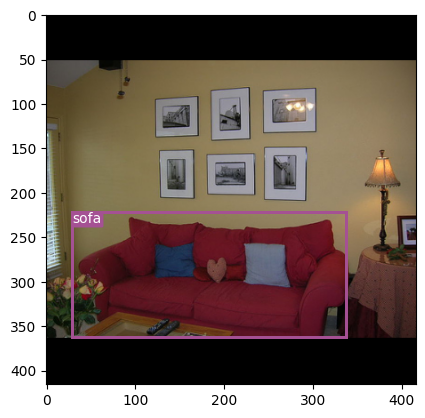

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
3
[[14.0, 1.0, 0.48399999737739563, 0.5730000138282776, 0.33800002932548523, 0.8500000238418579], [14.0, 1.0, 0.48399999737739563, 0.5730000138282776, 0.33800002932548523, 0.8500000238418579], [14.0, 1.0, 0.48399999737739563, 0.5730000138282776, 0.33800002932548523, 0.8500000238418579]]


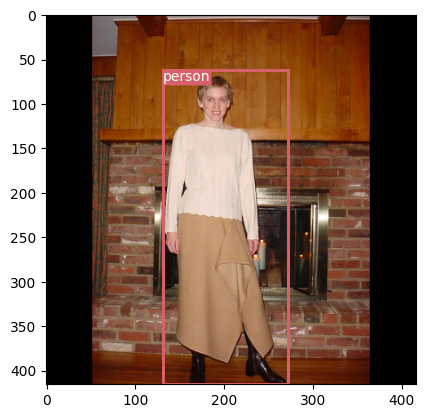

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
3
[[12.0, 1.0, 0.4880000054836273, 0.510780930519104, 0.9760000109672546, 0.7589112520217896], [12.0, 1.0, 0.4880000054836273, 0.510780930519104, 0.9760000109672546, 0.7589112520217896], [12.0, 1.0, 0.4880000054836273, 0.510780930519104, 0.9760000109672546, 0.7589112520217896]]


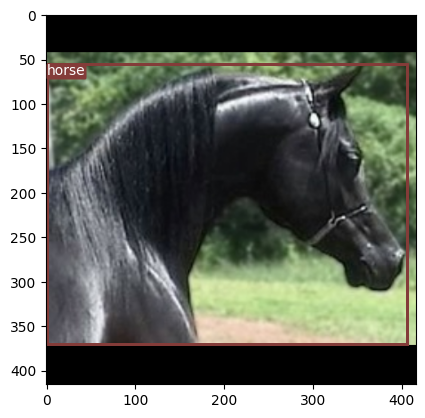

In [4]:
class YOLODataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13,26,52],
        C=20,
        transform=None
        ):

        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2]) # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist() # [class,x,y,w,h] -> [x,y,w,h,class]
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]


        # Ground Truth ..?
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S] # 6 -> [objectness, x, y, w, h, class]

        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False, False, False]

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale  # scale -> 0, 1, 2
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale # an anchor of particular scale -> 0, 1, 2
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x) # e.g. x = 0.5, S = 13 --> int(6.5) = 6th cell of x
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1 # objectness = 1
                    x_cell, y_cell = S*x - j, S*y - i # both are between [0, 1] e.g. 6.5 - 6 = 0.5

                    width_cell, height_cell = (       # ground truth에 w, h를 log(bw/pw), log(bh/ph)로 넣지 않는 이유..?
                        width * S,  # e.g. S = 13, width = 0.5, 6.5
                        height * S
                    )

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:  # box가 현재 scale_idx에 대한 anchor 할당을 iou가 가장 높은거로 받았으나 각 scale당 3개의 anchor가 존재하므로 iou가 가장 높은거 이외의 것들이 여기로 온다?
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore this predicion

        return image, tuple(targets)
    
    
def test():
    anchors = ANCHORS

    transform = test_transform

    dataset = YOLODataset(
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    cnt = 0


    for x, y in loader:
        cnt += 1
        if cnt == 4:
            break

        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print(len(boxes))
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


if __name__ == "__main__":
    test()

# model.py

In [5]:
# model.py
import torch
import torch.nn as nn

"""
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride)
Every conv is a same convolution.
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""

# Tuple: (out_channels, kernel_size, stride)
# List: ["B", n] 'B'is residual block, 'n' is number of repeat
Sequence = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)



class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels//2, kernel_size=1),
                    CNNBlock(channels//2, channels, kernel_size=3, padding=1)
                )
            ]

        self.use_residulal = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residulal:
                x = x + layer(x)     # skip connection
            else:
                x = layer(x)

        return x



class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),

            # (4 + 1 + num_classes) * 3 : 4 for [x, y, w, h], 1 for objectness prediction, 3 for anchor boxes per grid cell
            CNNBlock(2*in_channels, 3 * (4 + 1 + num_classes), bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return(
            self.pred(x)

            # x = [batch_num, 3*(num_classes + 5), N, N] ..?
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )
        # output = [B x 3 x N x N x 5+num_classes]



class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = [] # for each scale
        route_connections = [] # for concatenate

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue    # Since this is the output of each scale, it must skip x = ScalePrediction(x).

            x = layer(x)
            # print(x.shape)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in Sequence:
            if isinstance(module, tuple):    # CNN Block
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):  # Residual Block
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats= num_repeats,))

            elif isinstance(module, str):   #  Scale prediction block or Upsampling
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels//2, kernel_size=1),
                        ScalePrediction(in_channels//2, num_classes=self.num_classes),
                    ]

                    # Since we skip x = ScalePrediction(x), we need to change the channel to suit the previous CNNBlock.
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3   # because of concatenate

        return layers




In [6]:
# model test
# import config
num_classes = 20
IMAGE_SIZE = 416
model = YOLOv3(num_classes=num_classes)

x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
out = model(x)
assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
print("Success!")

Success!


# loss.py

In [7]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # constants
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # predictions -> [objectness, x, y, w, h, class] ..?

        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # No object Loss
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj])
        )

        # Object Loss
        anchors = anchors.reshape(1, 3, 1, 1, 2) # 3(anchor) x 2(h, w), p_w * exp(t_w)를 연산하기 위해 reshape
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj])) # target과 iou로 겹치는 정도만 gt로 반영

        # Box Coordinate Loss ->  이걸 그냥 CIoU로 ?
        # object detection box loss iou 검색 -> https://learnopencv.com/iou-loss-functions-object-detection/
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) # x, y to be between [0, 1]
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])


        # Class Loss
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long())
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

# train.py

In [8]:
# Define the train function to train the model
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    # Creating a progress bar
    progress_bar = tqdm(loader, leave=True)

    # Initializing a list to store the losses
    losses = []

    # Iterating over the training data
    for _, (x, y) in enumerate(progress_bar):
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE),
        )

        with torch.cuda.amp.autocast():
            # Getting the model predictions
            outputs = model(x)
            # Calculating the loss at each scale
            loss = (
                  loss_fn(outputs[0], y0, scaled_anchors[0])
                + loss_fn(outputs[1], y1, scaled_anchors[1])
                + loss_fn(outputs[2], y2, scaled_anchors[2])
            )

        # Add the loss to the list
        losses.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        scaler.scale(loss).backward()

        # Optimization step
        scaler.step(optimizer)

        # Update the scaler for next iteration
        scaler.update()

        # update progress bar with loss
        mean_loss = sum(losses) / len(losses)
        progress_bar.set_postfix(loss=mean_loss)

In [11]:
# Creating the model from YOLOv3 class
model = YOLOv3().to(DEVICE)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Defining the train dataset
train_dataset = YOLODataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
    img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=train_transform
)

# Defining the train data loader
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle = True,
    pin_memory = True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) * 
    torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(DEVICE)

# Training the model
for e in range(1, EPOCHS+1):
    print("Epoch:", e)
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    # Saving the model
    if SAVE_MODEL:
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=37.8]


=> Saving checkpoint
Epoch: 2


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=24.6]


=> Saving checkpoint
Epoch: 3


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=20.9]


=> Saving checkpoint
Epoch: 4


100%|██████████| 518/518 [05:42<00:00,  1.51it/s, loss=18.8]


=> Saving checkpoint
Epoch: 5


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=17.5]


=> Saving checkpoint
Epoch: 6


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=16.5]


=> Saving checkpoint
Epoch: 7


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=15.7]


=> Saving checkpoint
Epoch: 8


100%|██████████| 518/518 [05:41<00:00,  1.51it/s, loss=15]  


=> Saving checkpoint
Epoch: 9


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=14.3]


=> Saving checkpoint
Epoch: 10


100%|██████████| 518/518 [05:41<00:00,  1.52it/s, loss=13.7]


=> Saving checkpoint


=> Loading checkpoint
1
[[6.0, 0.723840594291687, 0.4973871111869812, 0.5009778738021851, 0.7603485584259033, 0.45210546255111694], [6.0, 0.6904123425483704, 0.5096887946128845, 0.509494960308075, 0.5798047184944153, 0.4982541799545288], [6.0, 0.6842074394226074, 0.49086692929267883, 0.5094457268714905, 0.5962080359458923, 0.4618838429450989], [6.0, 0.6719733476638794, 0.49077990651130676, 0.4903143048286438, 0.6217755675315857, 0.491722971200943], [18.0, 0.6645956635475159, 0.4460693299770355, 0.5155466794967651, 0.6328800320625305, 0.4316830337047577], [6.0, 0.6586830615997314, 0.5101495981216431, 0.49042704701423645, 0.5976278185844421, 0.5603830814361572], [18.0, 0.6556806564331055, 0.48118919134140015, 0.5153192281723022, 0.7731813788414001, 0.42760783433914185], [6.0, 0.6513569951057434, 0.4718378782272339, 0.5099024176597595, 0.5316011309623718, 0.431846022605896], [6.0, 0.6480588316917419, 0.47164419293403625, 0.49069225788116455, 0.5265933871269226, 0.4696323275566101], [6.0, 

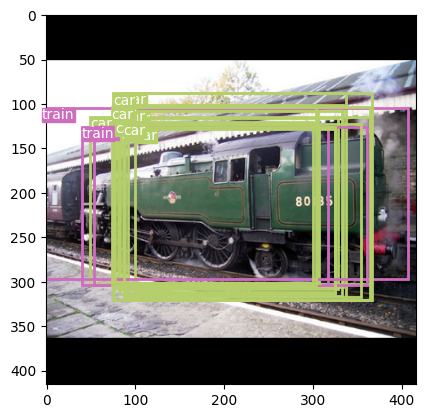

In [52]:
# Taking a sample image and testing the model

# Setting the load_model to True
LOAD_MODEL = True

# Defining the model, optimizer, loss function and scaler
model = YOLOv3().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss_fn = YOLOLoss()
scaler = torch.cuda.amp.GradScaler()

# Loading the checkpoint
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_FILE, model, optimizer, LEARNING_RATE)

# Defining the test dataset and data loader
test_dataset = YOLODataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv",
    img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=test_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 1,
    num_workers = 2,
    shuffle = True,
)

# Getting a sample image from the test data loader
x, y = next(iter(test_loader))
x = x.to(DEVICE)

model.eval()
with torch.no_grad():
    # Getting the model predictions
    output = model(x)
    # Getting the bounding boxes from the predictions
    bboxes = [[] for _ in range(x.shape[0])]
    anchors = (
            torch.tensor(ANCHORS)
                * torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
            ).to(DEVICE)

    # Getting bounding boxes for each scale
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = anchors[i]
        boxes_scale_i = cells_to_bboxes(
                            output[i], anchor, S=S, is_preds=True
                        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
model.train()

print(len(bboxes))
# Plotting the image with bounding boxes for each image in the batch
for i in range(1):
    # Applying non-max suppression to remove overlapping bounding boxes
    nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6)
    print(nms_boxes)
    # Plotting the image with bounding boxes
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)
    
    



In [63]:
train_dataset = YOLODataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv",
    img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=train_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 4,
    shuffle = True,
)

# mAP test 
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold=NMS_IOU_THRESH,
    anchors=ANCHORS,
    threshold=CONF_THRESHOLD,
)


  0%|          | 0/155 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [67]:
# get_evaluation_bboxes 계속 돌리면 오래걸리니까 따로 여기서 실행 
mapval = mAP(
    pred_boxes,
    true_boxes,
    iou_threshold=MAP_IOU_THRESH,
    box_format="midpoint",
    num_classes=NUM_CLASSES,
)

print(f"MAP: {mapval.item()}")

MAP: 0.04540960118174553
